In [1]:
import tqdm
import pandas as pd
import torch
import seaborn as sns
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### データの読み込み
表形式のデータを扱うのに長けた，pandasでデータを読み込む。
pandasにはread_csv()やread_excel()関数があり，一般的な表形式データをそのまま読み込むことができる。

In [2]:
df = pd.read_csv("./data/CarPrice_Assignment.csv")

Jupyter Notebook形式でスクリプトを書いている場合，セルの最終行に変数名だけを記載した場合，その内容が表示される。
その他の場所で表示がしたい場合はprint()関数の使用が必要

In [3]:
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


## データの整形
ダウンロードしたままの形出は，ニューラルネットワークへ直接入力を行うことができない。ここでは入力できる形へデータを整形する。

### 予測に意味をなさないデータの除外
読み込んだデータには，車の名称など，直接的に価格に結びつきにくいデータが含まれている。そういったデータを除外する。

※言語モデルを用いて「ポルシェだから高そう」や「高級そうな車種名だ」といった情報を加えたい場合，話は別
※単純に数値かする上でも，車種名を省いてメーカー名のみ抽出すれば情報として有意義かもしれない

In [4]:
# 学習から除外する列を指定
drop_columns = ["car_ID", "CarName"]

# dfをコピー
df_buf = df.drop(drop_columns, axis=1)

### 文字列で記録されたデータの数値化
読みこんだデータには，文字列が多分に含まれている。先週扱った通り，ニューラルネットワークは「数値（数は問わない）」を入力して「数値（数は問わない）」を出力する。従って，例えば燃料タイプの"gas"や"diesel"は，何かしらの数値へ変換する必要がある。ここでは，アルファベット順にソートした名称順に0,1,2...と数値化を行う。

In [5]:
# 列に対してループ
for column in df_buf.columns:
    
    # 列名称とデータ型を表示
    print(f"-----------------------------------------")
    print(f"col name: {column}, dtype: {df_buf[column].dtype}")

    # ユニークな値のリストを表示
    print(f"unique values:{df_buf[column].unique()}")
    
    # object型の列に対しては，ユニークな値を0始まりの整数に置換
    if df_buf[column].dtype == "object":
        df_buf[column] = pd.Categorical(df[column])
        df_buf[column] = df_buf[column].cat.codes
        print(f"convert:{df_buf[column].unique()}")


-----------------------------------------
col name: symboling, dtype: int64
unique values:[ 3  1  2  0 -1 -2]
-----------------------------------------
col name: fueltype, dtype: object
unique values:['gas' 'diesel']
convert:[1 0]
-----------------------------------------
col name: aspiration, dtype: object
unique values:['std' 'turbo']
convert:[0 1]
-----------------------------------------
col name: doornumber, dtype: object
unique values:['two' 'four']
convert:[1 0]
-----------------------------------------
col name: carbody, dtype: object
unique values:['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
convert:[0 2 3 4 1]
-----------------------------------------
col name: drivewheel, dtype: object
unique values:['rwd' 'fwd' '4wd']
convert:[2 1 0]
-----------------------------------------
col name: enginelocation, dtype: object
unique values:['front' 'rear']
convert:[0 1]
-----------------------------------------
col name: wheelbase, dtype: float64
unique values:[ 88.6  94.5  99

### データの数値レンジの正規化
今回のデータにおいては，燃料タイプは0-1で，重量は2548-3062の範囲で分布している。
これらのデータの最大値と最小値の差は，1と514で，このままモデルに入力を行った場合，このバランスを取るために訓練のリソース消費される。
意図的に何かのデータを重視したい場合を除いては，これらの値は同じスケールに統一したほうがよい。
そういった処理としてMin-Max normalization という，最小値を0，最大値を1で統一する正規化手法が存在する。

In [6]:
for column in df_buf.columns:
    print(f"col name: {column}, min: {df_buf[column].min()}, max: {df_buf[column].max()}")
    df_buf[column] = (df_buf[column] - df_buf[column].min()) / (df_buf[column].max() - df_buf[column].min())

col name: symboling, min: -2, max: 3
col name: fueltype, min: 0, max: 1
col name: aspiration, min: 0, max: 1
col name: doornumber, min: 0, max: 1
col name: carbody, min: 0, max: 4
col name: drivewheel, min: 0, max: 2
col name: enginelocation, min: 0, max: 1
col name: wheelbase, min: 86.6, max: 120.9
col name: carlength, min: 141.1, max: 208.1
col name: carwidth, min: 60.3, max: 72.3
col name: carheight, min: 47.8, max: 59.8
col name: curbweight, min: 1488, max: 4066
col name: enginetype, min: 0, max: 6
col name: cylindernumber, min: 0, max: 6
col name: enginesize, min: 61, max: 326
col name: fuelsystem, min: 0, max: 7
col name: boreratio, min: 2.54, max: 3.94
col name: stroke, min: 2.07, max: 4.17
col name: compressionratio, min: 7.0, max: 23.0
col name: horsepower, min: 48, max: 288
col name: peakrpm, min: 4150, max: 6600
col name: citympg, min: 13, max: 49
col name: highwaympg, min: 16, max: 54
col name: price, min: 5118.0, max: 45400.0


In [7]:
df_buf

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1.0,1.0,0.0,1.0,0.00,1.0,0.0,0.058309,0.413433,0.316667,...,0.260377,0.714286,0.664286,0.290476,0.12500,0.262500,0.346939,0.222222,0.289474,0.207959
1,1.0,1.0,0.0,1.0,0.00,1.0,0.0,0.058309,0.413433,0.316667,...,0.260377,0.714286,0.664286,0.290476,0.12500,0.262500,0.346939,0.222222,0.289474,0.282558
2,0.6,1.0,0.0,1.0,0.50,1.0,0.0,0.230321,0.449254,0.433333,...,0.343396,0.714286,0.100000,0.666667,0.12500,0.441667,0.346939,0.166667,0.263158,0.282558
3,0.8,1.0,0.0,0.0,0.75,0.5,0.0,0.384840,0.529851,0.491667,...,0.181132,0.714286,0.464286,0.633333,0.18750,0.225000,0.551020,0.305556,0.368421,0.219254
4,0.8,1.0,0.0,0.0,0.75,0.0,0.0,0.373178,0.529851,0.508333,...,0.283019,0.714286,0.464286,0.633333,0.06250,0.279167,0.551020,0.138889,0.157895,0.306142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.2,1.0,0.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.716667,...,0.301887,0.714286,0.885714,0.514286,0.15625,0.275000,0.510204,0.277778,0.315789,0.291123
201,0.2,1.0,1.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.708333,...,0.301887,0.714286,0.885714,0.514286,0.10625,0.466667,0.469388,0.166667,0.236842,0.345738
202,0.2,1.0,0.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.716667,...,0.422642,0.714286,0.742857,0.380952,0.11250,0.358333,0.551020,0.138889,0.184211,0.406311
203,0.2,0.0,1.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.716667,...,0.316981,0.428571,0.335714,0.633333,1.00000,0.241667,0.265306,0.361111,0.289474,0.430763


## データを訓練・テストに分割
データ全てを使って訓練すると，過学習（問題集の丸暗記に近い状態）となり，初めて見るデータに対する推測性能を知ることができない。
整形したデータの２割を，テストデータ，８割を訓練データとして分割する。

In [8]:
# 価格を予測するため，price列をyとして分ける
X = df_buf.drop("price", axis=1)
y = df_buf["price"]

# 分割の再現性を確保するため，シード値を指定したうえで訓練データ・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


分割結果の確認

In [9]:
X_train

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
4,0.8,1.0,0.0,0.0,0.75,0.0,0.0,0.373178,0.529851,0.508333,...,0.166667,0.283019,0.714286,0.464286,0.633333,0.06250,0.279167,0.551020,0.138889,0.157895
71,0.2,1.0,0.0,0.0,0.75,1.0,0.0,0.845481,0.917910,0.950000,...,0.000000,0.652830,0.714286,0.657143,0.490476,0.08125,0.445833,0.244898,0.083333,0.052632
134,1.0,1.0,0.0,1.0,0.50,0.5,0.0,0.364431,0.679104,0.516667,...,0.333333,0.226415,0.714286,0.000000,0.000000,0.14375,0.258333,0.448980,0.222222,0.315789
145,0.4,1.0,1.0,0.0,0.75,0.0,0.0,0.303207,0.461194,0.425000,...,0.333333,0.177358,0.714286,0.771429,0.271429,0.04375,0.262500,0.265306,0.305556,0.342105
122,0.6,1.0,0.0,0.0,0.75,0.5,0.0,0.206997,0.391045,0.291667,...,0.333333,0.139623,0.142857,0.307143,0.552381,0.15000,0.083333,0.551020,0.500000,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.2,0.0,1.0,0.0,0.75,1.0,0.0,0.682216,0.743284,0.833333,...,0.166667,0.460377,0.428571,0.742857,0.747619,0.90625,0.312500,0.081633,0.250000,0.236842
192,0.4,0.0,1.0,0.0,0.75,0.5,0.0,0.402332,0.583582,0.550000,...,0.333333,0.135849,0.428571,0.335714,0.633333,1.00000,0.083333,0.142857,0.555556,0.578947
117,0.4,1.0,1.0,0.0,0.75,1.0,0.0,0.623907,0.680597,0.666667,...,0.333333,0.275472,0.714286,0.764286,0.542857,0.00000,0.391667,0.591837,0.138889,0.210526
47,0.4,1.0,0.0,0.0,0.75,1.0,0.0,0.769679,0.873134,0.775000,...,0.500000,0.743396,0.714286,0.778571,1.000000,0.06875,0.533333,0.244898,0.055556,0.078947


In [10]:
X_test.shape

(41, 23)

In [11]:
y_train.shape

(164,)

In [12]:
y_test.shape

(41,)

## データをpytorch用に変換
データを変換し，モデルが読み込めるようにデータローダーを定義する。

In [13]:
# torchテンソルに変換
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

# データローダー定義用に変換
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# データローダー定義
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=23, shuffle=False)


In [14]:
# テンソル形状の確認
for batch, (X, y) in enumerate(train_loader):
    pass
print(f"batch: {batch}, X: {X.shape}, y: {y.shape}")

batch: 40, X: torch.Size([4, 23]), y: torch.Size([4, 1])


## モデルの定義
モデルの定義自体は基本的に前回の分類問題と同様。
変更するのは，入出力データのサイズ。

### 前回の入出力サイズ
入力：縦横28ピクセルのモノクロ画像データのため，１ピクセル毎の輝度データが入力，つまり28×28=784個の数値を入力とした。
出力：10種類の衣類の種類それぞれの確率を数字としたため，10個の数字が出力

### 今回の入出力サイズ
入力：23列の各パラメータが対応するため，数値23個を入力する。
出力：価格，つまり単一の数値が出力


In [15]:
input_size = X.shape[1]
output_size = 1

In [16]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# モデルのインスタンスを作成
model = NeuralNetwork(input_size=input_size, output_size=output_size).to(device)
train_error = []; test_error = []; total_epochs = 0
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=23, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): ReLU()
  )
)


## 訓練条件の指定
損失関数，最適化アルゴリズムを指定する。
前回と違うのは，損失関数が単純に数値の誤差のため，MSELoss()を使用する点


In [ ]:
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#学習スケジューラーを入れる場合はここに記述

In [ ]:
def train(dataloader, model, loss_fn, optimizer, scheduler = None):

    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current = batch * len(X)
    total_loss /= size
    total_error = total_loss**0.5*100

    if scheduler is not None:
        try:
            scheduler.step(loss)
        except:
            scheduler.step

    return total_error

def test(dataloader, model, loss_fn, monitor = False, range = (0,1)):
    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0

    if monitor:
        predictions = []
        truths = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            if monitor:
                predictions.append(pred)
                truths.append(y)

            test_loss += loss_fn(pred, y).item()
    test_loss /= size
    test_error = test_loss**0.5*100

    if monitor:
        predictions = torch.cat(predictions).cpu().numpy() * (range[1] - range[0]) + range[0]
        truths = torch.cat(truths).cpu().numpy() * (range[1] - range[0]) + range[0]
        plt.plot([range[0],range[1]], [range[0],range[1]], color = "black")
        plt.plot(truths, predictions, "o", color = "black", alpha = 0.5)
        plt.xlabel("True Price [USD]")
        plt.ylabel("Predicted Price[USD]")
        #rmseをテキストとして枠内に表示
        plt.text(0.05, 0.95, f"RMSE: {test_error/100* (range[1] - range[0]):.2f}", transform=plt.gca().transAxes)
        plt.show()
        

    return test_error

In [19]:
epochs = 5
total_epochs += epochs
for t in tqdm.tqdm(range(epochs)):
    train_error.append(train(train_loader, model, loss_fn, optimizer))
    test_error.append(test(test_loader, model, loss_fn))
print("完了")

100%|██████████| 5/5 [00:00<00:00, 20.40it/s]

完了


## 学習曲線の可視化

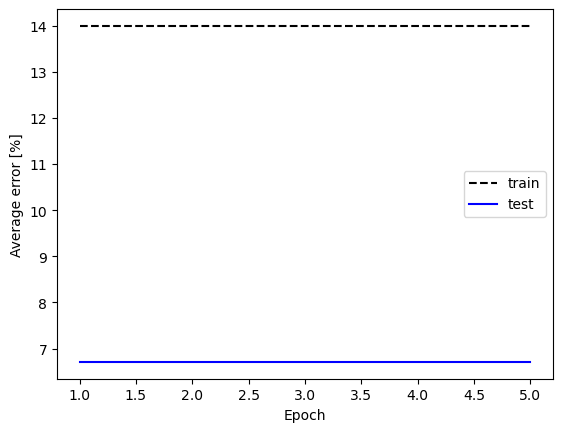

In [20]:

plt.plot(range(1,total_epochs+1), train_error, label="train", color="black", linestyle="dashed")
plt.plot(range(1,total_epochs+1), test_error, label="test", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Average error [%]")
plt.legend()
plt.show()


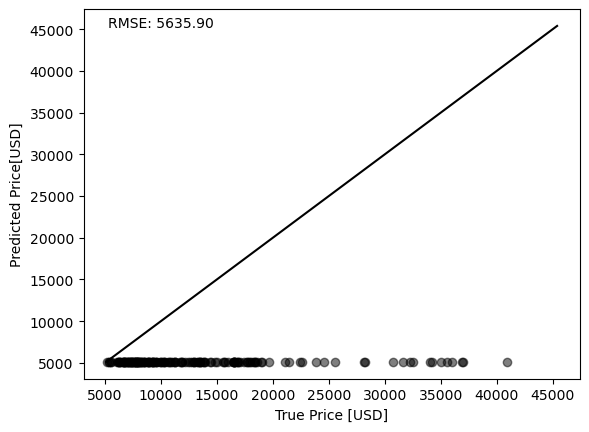

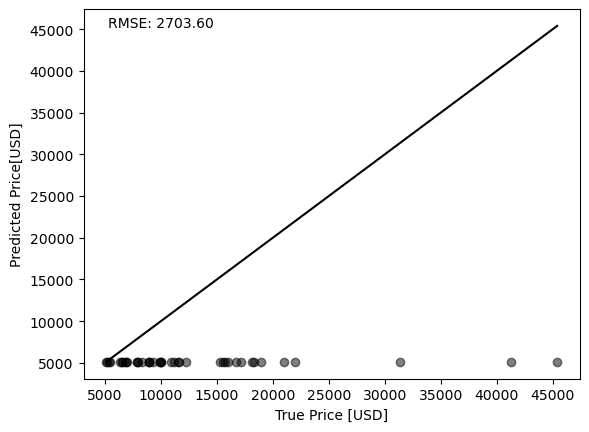

6.711692982428668

In [21]:
# 訓練データに対する予測結果を表示
test(train_loader, model, loss_fn, monitor=True, range = (df["price"].min(), df["price"].max()))
# テストデータに対する予測結果を表示
test(test_loader, model, loss_fn, monitor=True, range = (df["price"].min(), df["price"].max()))

## 精度向上へのヒント
1. データの前処理は正しかったか？
    1. CarNameは全カットで良かったか？「メーカー名 車名」となっているので，車名は有効活用できない？
    1. cylindernumberはアルファベット順に並べると，eight，five，four，six，three，twelve，twoとなる。この順番が余計な非線形性を生んでいないか？（enginetype，fuelsystemでも同様のことが言えないか？）
1. 学習量（エポック数）は充分か？
    1. 学習曲線におけるテストデータの誤差が減少傾向であれば，学習不足。
    1. テストデータよりも訓練データに対する誤差が大きい場合も，学習不足の可能性が高い。
1. 学習速度係数は適切か？
    1. 大きいと収束は早いが安定しにくい。
    1. 小さいと収束結果はいいが学習が遅い。
    1. 学習の途中で学習係数を調整するスケジューラーも存在する（from torch.optim import lr_scheduler）
1. モデルの表現力（層の数やニューロンの数）は適切だったか？
    1. 表現力が不足していると，データ全てを包括した特徴を充分に抽出できない。この場合，学習曲線で訓練データの誤差が一定値以上減らなくなる。
    1. 表現力が過剰な場合，過学習（訓練データを丸暗記し，テスト結果が悪くなる）に陥りやすい。この場合，学習曲線において訓練データに対する誤差が減っているにも関わらず，テストデータに対する誤差が増えていく。
1. 損失関数は適切だったか？回帰における誤差評価関数には例えば以下のような種類がある。
    1. MSE（Mean Squared Error/2乗平均誤差）：正規分布の分散に相当する。2乗を取ることで本来の値から離れるほど非線形にペナルティが大きくなる
    1. RMSE（Root Mean Squared Error/2乗平均平方根誤差）：正規分布の標準偏差に相当する。本来の値からの距離に対して線形にペナルティを与える。
    1. MAE（Mean Absolute Error/平均絶対値誤差）：誤差自体の平均値
    1. LMSE(Least Mean Square Error/最小2乗平均誤差)：MSEの対数をとった関数。誤差を対数軸（比率）で評価可能になるので，何桁にも渡って分布する（対数軸で評価する）回帰対象に対して適用しやすい。
    

## 同条件でのスコア統計取得
モデルの初期パラメータは，乱数で決定される。ので，同じ方法での訓練でも結果はばらつく。複数回の評価で，本質的に優れた方法かが評価できる。

In [22]:
n = 30
errors = []
for i in range(n):
    model = NeuralNetwork(input_size=input_size, output_size=output_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #学習スケジューラーを入れる場合はここに記述

    for t in range(epochs):
        train_RMSE = train(train_loader, model, loss_fn, optimizer)/ 100 * (df["price"].max() - df["price"].min())
        test_RMSE = test(test_loader, model, loss_fn)/ 100 * (df["price"].max() - df["price"].min())
    errors.append((train_RMSE, test_RMSE))

    print(f"\r{i+1}/{n}: train_RMSE: {train_RMSE:.2f}, test_RMSE: {test_RMSE:.2f}", end='')




30/30: train_RMSE: 5635.90, test_RMSE: 2703.60

(30, 2)


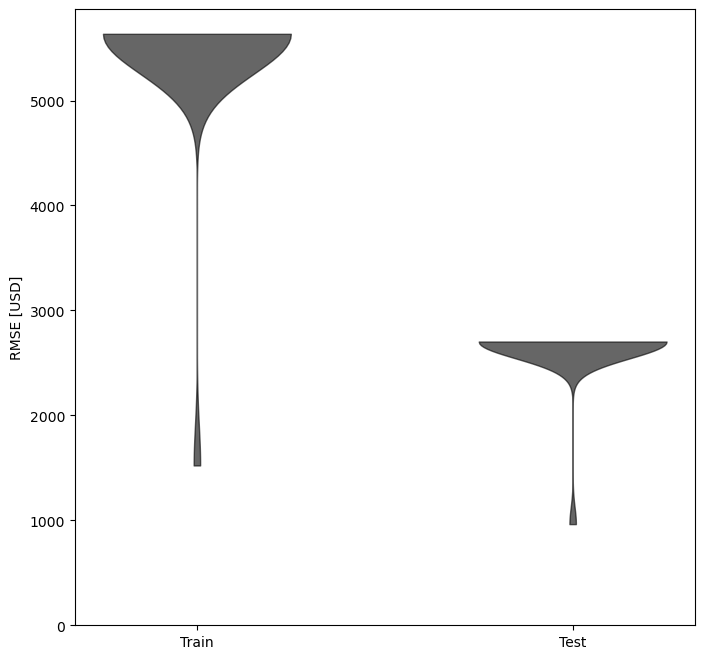

In [23]:
# 繰り返した結果のバイオリンプロットを表示
error = torch.tensor(errors)
error = error.cpu().numpy()
error = error 
print(error.shape)
fig, ax = plt.subplots(figsize=(8,8))
vio = ax.violinplot(error, showmeans=False, showextrema=False, showmedians=False)
ax.set_xticks([1,2], labels=["Train", "Test"])
for body in vio['bodies']:
    body.set_color('black')
    body.set_alpha(0.6)
plt.ylabel("RMSE [USD]")
plt.ylim(0, )
plt.show()

In [24]:
# RMSEの統計をcsvに保存
df_error = pd.DataFrame(errors, columns=["Train", "Test"])
df_error.to_csv("./data/RMSE.csv")



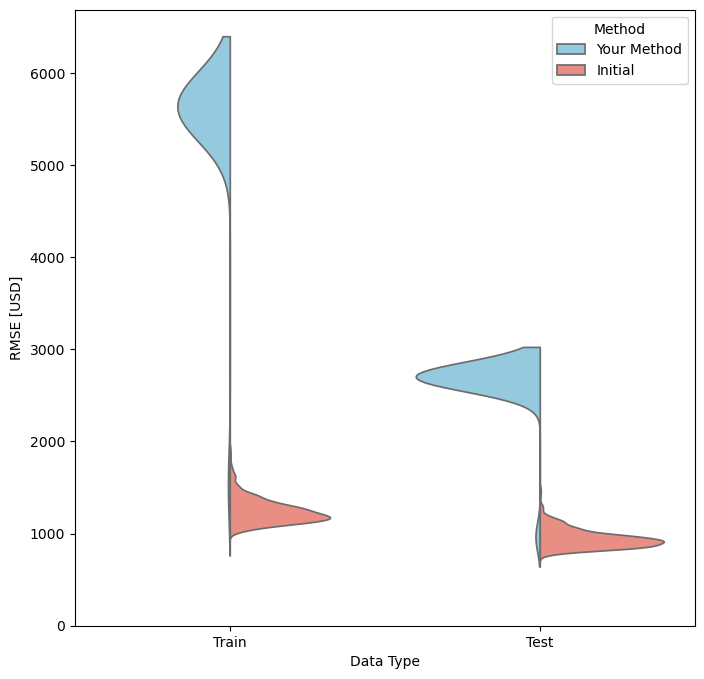

In [25]:
#比較用に整形
df_ref = pd.read_csv("./data/RMSE_of_Initial_Conditions.csv")
df_ref_train = pd.DataFrame({'RMSE': df_ref['Train']})
df_ref_train['Data Type'] = 'Train'
df_ref_test = pd.DataFrame({'RMSE': df_ref['Test']})
df_ref_test['Data Type'] = 'Test'
df_ref_combined = pd.concat([df_ref_train, df_ref_test])
df_ref_combined['Method'] = 'Initial'

df_error_train = pd.DataFrame({'RMSE': df_error['Train']})
df_error_train['Data Type'] = 'Train'
df_error_test = pd.DataFrame({'RMSE': df_error['Test']})
df_error_test['Data Type'] = 'Test'
df_error_combined = pd.concat([df_error_train, df_error_test])
df_error_combined['Method'] = 'Your Method'

df_combined = pd.concat([df_error_combined, df_ref_combined])

#比較
f,ax=plt.subplots(figsize=(8,8))
sns.violinplot(x= "Data Type",y="RMSE",hue="Method", data=df_combined, split=True, ax=ax, inner=None, palette=["skyblue", "salmon"])
ax.set_ylabel("RMSE [USD]")
ax.set_ylim(0,)
plt.show()


In [26]:
df_combined

,RMSE,Data Type,Method
0,5635.900671,Train,Your Method
1,5635.900665,Train,Your Method
2,5635.900605,Train,Your Method
3,5635.900699,Train,Your Method
4,5635.900655,Train,Your Method
...,...,...,...
995,805.273364,Test,Initial
996,821.528080,Test,Initial
997,1022.083762,Test,Initial
998,929.302983,Test,Initial
